In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [55]:
# Load data
data = pd.read_csv("../src/data/merged_data.csv", parse_dates=["Date"], index_col="Date")

In [ ]:
# --------------------------
# 1. Data Preprocessing
# --------------------------
# Split data first
train_size = int(len(data) * 0.8)
train_raw, test_raw = data.iloc[:train_size], data.iloc[train_size:]

# Scale using only training data
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_raw), 
                           columns=data.columns, 
                           index=train_raw.index)
test_scaled = pd.DataFrame(scaler.transform(test_raw), 
                          columns=data.columns, 
                          index=test_raw.index)

# Ensure no NaN values
train = train_scaled.dropna()
test = test_scaled.dropna()

In [57]:
# --------------------------
# 2. ARIMA Model
# --------------------------
arima_model = ARIMA(train["Price"], order=(5,1,0)).fit()
arima_pred = arima_model.forecast(steps=len(test))

c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10

In [58]:
# --------------------------
# 3. GARCH Model
# --------------------------
scaled_price = train["Price"] * 10  # Rescale Price
garch_model = arch_model(scaled_price, vol='Garch', p=1, q=1, rescale=False).fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 441576962561.84973
Iteration:      2,   Func. Count:     16,   Neg. LLF: 71146720105.34631
Iteration:      3,   Func. Count:     23,   Neg. LLF: 856978871.3776429
Iteration:      4,   Func. Count:     29,   Neg. LLF: 10487.884962238506
Iteration:      5,   Func. Count:     34,   Neg. LLF: 10304.295870362965
Iteration:      6,   Func. Count:     46,   Neg. LLF: 9655.979252262961
Iteration:      7,   Func. Count:     51,   Neg. LLF: 179770390409.35413
Iteration:      8,   Func. Count:     66,   Neg. LLF: 753112.0553529745
Iteration:      9,   Func. Count:     79,   Neg. LLF: 55849.04185920563
Iteration:     10,   Func. Count:     94,   Neg. LLF: 10953.940485327956
Iteration:     11,   Func. Count:     99,   Neg. LLF: 6559068.932206704
Iteration:     12,   Func. Count:    106,   Neg. LLF: 1025108.5184233341
Iteration:     13,   Func. Count:    112,   Neg. LLF: 10431.087184883369
Iteration:     14,   Func. Count:    118,   Neg. LLF: 886

In [59]:
# --------------------------
# 4. VAR Model (Correct Column Selection)
# --------------------------
var_model = VAR(train)
var_fitted = var_model.fit(5)
var_pred = var_fitted.forecast(train.values[-5:], steps=len(test))

c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [61]:
# --------------------------
# 5. Markov-Switching Model
# --------------------------
markov_model = MarkovRegression(train["Price"], k_regimes=2, trend='c', switching_variance=True).fit()
markov_pred = markov_model.smoothed_marginal_probabilities

c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [60]:
# --------------------------
# 6. LSTM Model
# --------------------------
X_train, y_train = train["Price"].values[:-1], train["Price"].values[1:]
X_test, y_test = test["Price"].values[:-1], test["Price"].values[1:]
X_train, X_test = X_train.reshape(-1,1,1), X_test.reshape(-1,1,1)

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1,1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)
lstm_pred = lstm_model.predict(X_test)

Epoch 1/20


c:\Users\Administrator.MMCY\OneDrive - MMCYTECH\Desktop\10a\Birhan-Energies-W10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0557
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6475e-04
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.1524e-05
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2992e-05
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7285e-05
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6941e-05
Epoch 7/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.8505e-05
Epoch 8/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.0728e-05
Epoch 9/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9716e-05
Epoch 10/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0806e-05
Epoch 11/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3041e-05
Epoch 12/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3050e-05
Epoch 13/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3591e-05
Epoch 14/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.8958e-05
Epoch 15/20
457/

In [ ]:
# 7. Model Evaluation 
# --------------------------
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

evaluate_model(test["Price"], arima_pred, "ARIMA")
evaluate_model(test["Price"], var_pred[:,0], "VAR")  # Ensure first column is Price
evaluate_model(test["Price"].values[1:], lstm_pred.flatten(), "LSTM")

ARIMA - MAE: 0.1224, RMSE: 0.1470
VAR - MAE: 0.1172, RMSE: 0.1347
LSTM - MAE: 0.0081, RMSE: 0.0109


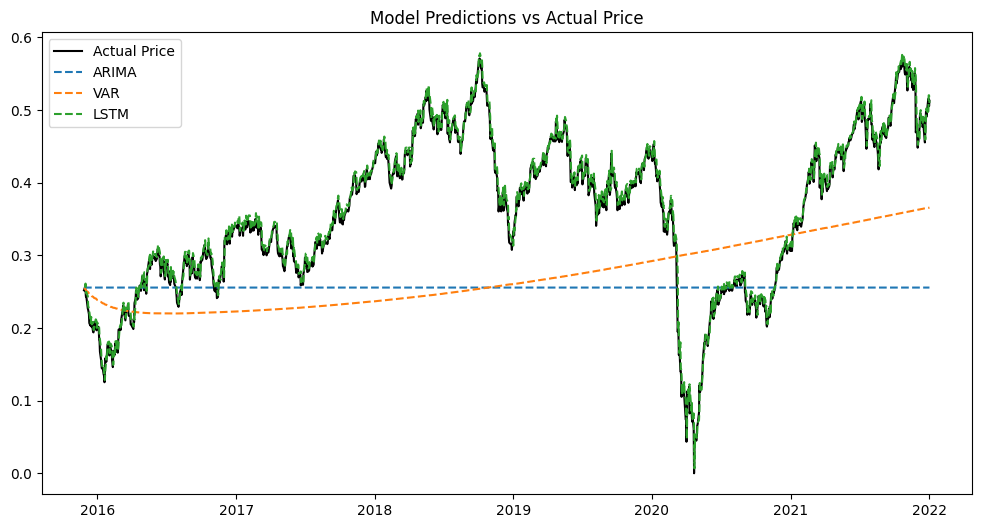

In [ ]:
# --------------------------
# 8. Visualization 
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(test.index, test["Price"], label="Actual Price", color='black')
plt.plot(test.index, arima_pred, label="ARIMA", linestyle='dashed')
plt.plot(test.index, var_pred[:,0], label="VAR", linestyle='dashed')
plt.plot(test.index[1:], lstm_pred, label="LSTM", linestyle='dashed')
plt.legend()
plt.title("Model Predictions vs Actual Price")
plt.show()